# Photolithography analysis
**Author:** Rowan Temple<br>
**Date created:** 17th Jan 2025<br>
**Date finalised:** 18th Jan 2025<br>
**Wafer:** abcd1234<br>
**Device:** bcde2345<br>
**Fabrication by:** Joe<br>
**Date of fabrication:** 2025-01-01<br>
**Date of TEM measurement:** 2025-01-02<br>


## Introduction
Here we analyse a calibration photolithography bar pattern imaged with TEM. The designed pattern is lines from 50 to 0.5um in size with 15um spacing. We are given the design file in GDS2 format.

Typical tasks required for the analysis includes detecting the structures, verifying their dimensions, and identifying any defects in, and yield of, the devices vs. designed parameters.

Below is shown the designed pattern used to create the structures that we will analyse.

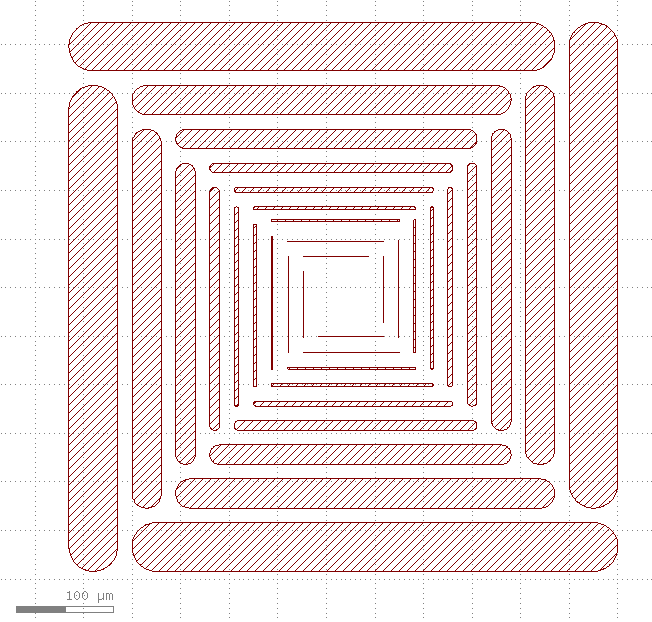

In [20]:
Image("./data/pattern_design.png")

## Setup
Import the libraries we're going to need.

In [1]:
from IPython.display import display, Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skimage import measure
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.transform import rescale

C:\Users\RowanTemple\miniconda3\envs\sandbox310\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


## Load and preprocess image
Load the TEM image file and visually check it.

Successfully laded TEM image. Dimension:  (2168, 2168, 3)


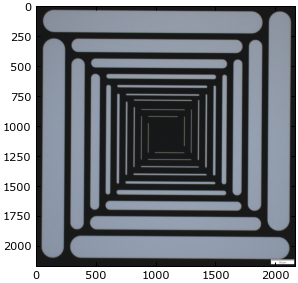

In [21]:
rdat = plt.imread("./data/Photolith pattern.png")

print("Successfully laded TEM image. Dimension: ", rdat.shape)
plt.imshow(rdat)

Convert RGB colours to 1-dimensional gray scale. This will simplify the analysis.

In [3]:
dat = rgb2gray(rdat)

## Threshold image
Binarize the image using Otsu thresholding technique. This will search for the best threshold on a generalised image even if the exposure or colours change.

In [4]:
thresh = threshold_otsu(dat)
binary = (dat > thresh).astype(np.uint8)

Plot the greyscale colour histogram to check the Otsu threshold chosen looks reasonable.

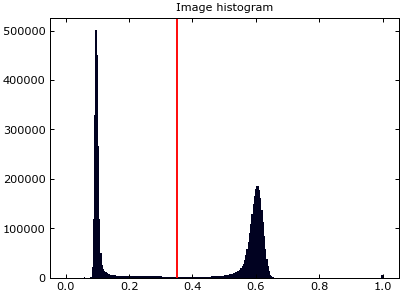

In [5]:
plt.hist(dat.ravel(), bins=256)
plt.title('Image histogram')
plt.axvline(thresh, color='r')

OK the detected color threshold looks good.

Now let's visually check the binarisation process:

Text(0.5, 1.0, 'Zoomed binarised')

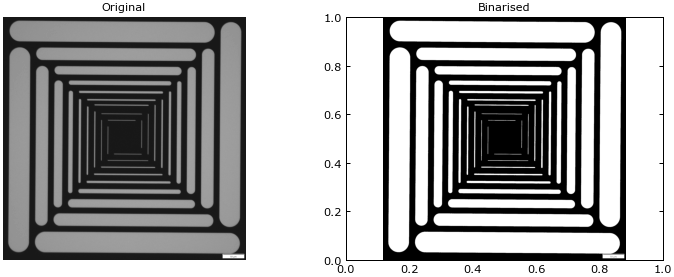

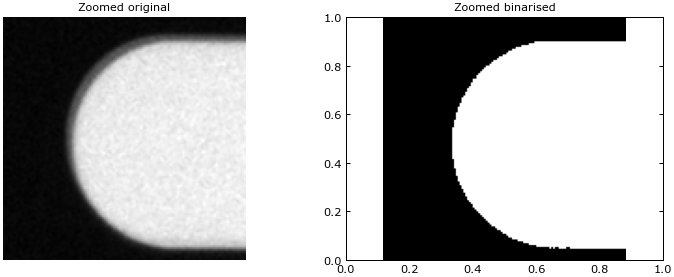

In [6]:
def create_image_comparison_figure():
    fig, axes = plt.subplots(ncols=2, figsize=(10, 3.5))
    ax = axes.ravel()
    ax[0] = plt.subplot(1, 2, 1)
    ax[1] = plt.subplot(1, 2, 2, sharex=ax[0], sharey=ax[0])
    [ax[i].axis('off') for i in range(2)]
    return ax


ax0, ax1 = create_image_comparison_figure()
ax0.imshow(dat, cmap="gray")
ax0.set_title('Original')
ax1.imshow(binary, cmap="gray")
ax1.set_title('Binarised')

# zoom in
ax0, ax1 = create_image_comparison_figure()
shpi, shpj = dat.shape
crop = (slice(round(shpi * 0.12), round(shpi * 0.18)),
        slice(round(shpj * 0.12), round(shpj * 0.18)))
ax0.imshow(dat[crop], cmap="gray")
ax0.set_title('Zoomed original')
ax1.imshow(binary[crop], cmap="gray")
ax1.set_title('Zoomed binarised')

At a high level the binary mask matches the image well. When we zoom in we see the feature boundary has some blurring. The blur is probably due to scattering or shadowing or other defects during the lithography. 

We also note our mask is quite pixelated. We can help solve this problem by resizing the image to 3x pixel density.

Text(0.5, 1.0, 'Binarised after rescale')

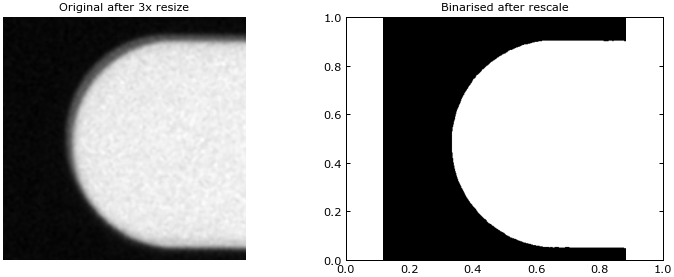

In [7]:
scaling_factor = 3
dat = rescale(dat, scaling_factor)
binary = (dat > thresh).astype(np.uint8)

ax0, ax1 = create_image_comparison_figure()
shpi, shpj = dat.shape
crop = (slice(round(shpi * 0.12), round(shpi * 0.18)),
        slice(round(shpj * 0.12), round(shpj * 0.18)))
ax0.imshow(dat[crop], cmap="gray")
ax0.set_title('Original after 3x resize')
ax1.imshow(binary[crop], cmap="gray")
ax1.set_title('Binarised after rescale')

We've got less edge defects on the mask now and more detail. The lithography shadowing effect is still present in the real image and the mask size is reflecting this. We can probably expect that the bar widths are going to be wider than the expected bar widths from the patterning GDS file.

## Determine image physical scaling using calibration bar

If we want to automate scaling (finding the image physical dimension). We need to isolate the scale bar on bottom right of the image. This is likely to be in the same pixel position each time for a given instrument so we can just hard code the coordinates of the bar. We'd have to revise this if the position wasn't consistent and do some kind of particle detection method to find the bar.

The 50um scale line width is 184 pixels. The total image size is 589.130 um x 589.130 um


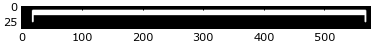

In [8]:
coord = np.array([2115, 1959, 2127, 2151]) * scaling_factor
scale_line_y = 2118 * scaling_factor
scaleim = np.logical_not(binary[coord[0]:coord[2], coord[1]:coord[3]])
scale_lw = np.sum(scaleim[scale_line_y - coord[0], :])
pix_to_um = 50 / scale_lw
fig, ax = plt.subplots(1, 1)
ax.imshow(scaleim, cmap="gray")
print(f"The 50um scale line width is {round(scale_lw / scaling_factor)} pixels. "
      f"The total image size is {binary.shape[1] * pix_to_um:.3f} um x "
      f"{binary.shape[0] * pix_to_um:.3f} um")

### Test scale
Let's double check the scale manually. From a visual inspection using ImageJ software I measure 184 pixels, verifying that the automated process has got an accurate value. Ideally we should also test the TEM distance calibration on a regular basis using a physical calibration sample. Ideally something on the wafer within range of the test device.

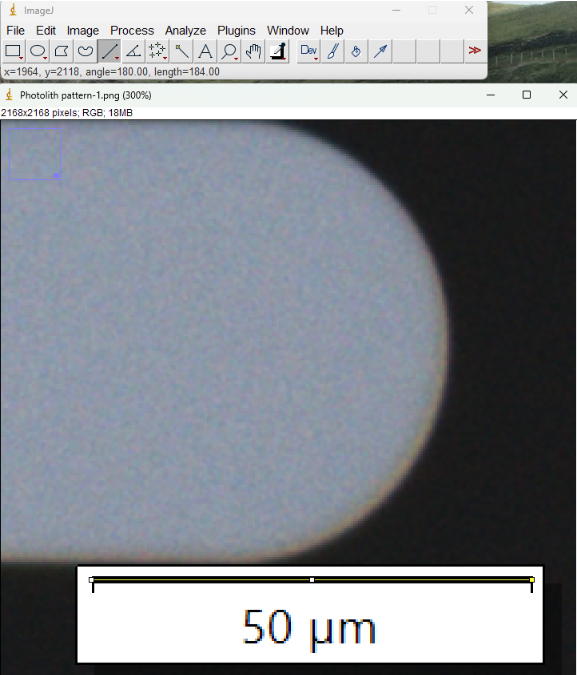

In [9]:
Image(filename='data/Scale bar screenshot.png')

## Detect and measure patterned bars
OK now we want to detect and analyse the bar pattern.

First detect and measure the properties of all the particles in the binarised image.

In [22]:
label_image = measure.label(binary)
properties = measure.regionprops(label_image)

df = {
    prop.label: {
        "device_label": "sample_1",
        "image": "Photolith pattern.png",
        "x_centre_pixels": prop.centroid[1] / scaling_factor,
        "y_centre_pixels": prop.centroid[0] / scaling_factor,
        "width_pix": (prop.bbox[3] - prop.bbox[1]) / scaling_factor,
        "height_pix": (prop.bbox[2] - prop.bbox[0]) / scaling_factor,
        "width_um": (prop.bbox[3] - prop.bbox[1]) * pix_to_um,
        "height_um": (prop.bbox[2] - prop.bbox[0]) * pix_to_um,
        "area_um2": prop.area * pix_to_um ** 2,
        "circumference_um": prop.perimeter * pix_to_um
    } for prop in properties
}
df = pd.DataFrame().from_dict(df, orient="index")
df.index.name = "feature_n"

Now visualise this result to verify the particle detection has worked well.

Feature properties (lengths in units of um unless specified as number of pixels):


,device_label,image,x_centre_pixels,y_centre_pixels,width_pix,height_pix,width_um,height_um,area_um2,circumference_um
feature_n,,,,,,,,,,
1,sample_1,Photolith pattern.png,973.973439,131.371962,1829.333333,196.333333,497.101449,53.351449,24335.633927,1081.192933
2,sample_1,Photolith pattern.png,2027.829742,960.031105,196.000000,1827.666667,53.260870,496.648551,24289.023118,1081.659811
3,sample_1,Photolith pattern.png,145.518185,1184.701089,196.000000,1827.666667,53.260870,496.648551,24389.998162,1087.177821
4,sample_1,Photolith pattern.png,1009.430580,332.753430,1425.333333,120.000000,387.318841,32.608696,11482.184349,830.712802
5,sample_1,Photolith pattern.png,1826.441245,995.647272,120.666667,1425.000000,32.789855,387.228261,11522.625236,830.037454
6,sample_1,Photolith pattern.png,347.091059,1149.419861,120.000000,1425.000000,32.608696,387.228261,11498.798834,836.106484
7,sample_1,Photolith pattern.png,1026.622505,479.039935,1133.000000,82.000000,307.880435,22.282609,6135.963099,656.073827
8,sample_1,Photolith pattern.png,1680.088267,1013.130141,82.333333,1132.333333,22.373188,307.699275,6169.536665,656.514955
9,sample_1,Photolith pattern.png,493.049100,1132.442605,82.000000,1132.666667,22.282609,307.789855,6179.858157,658.656224


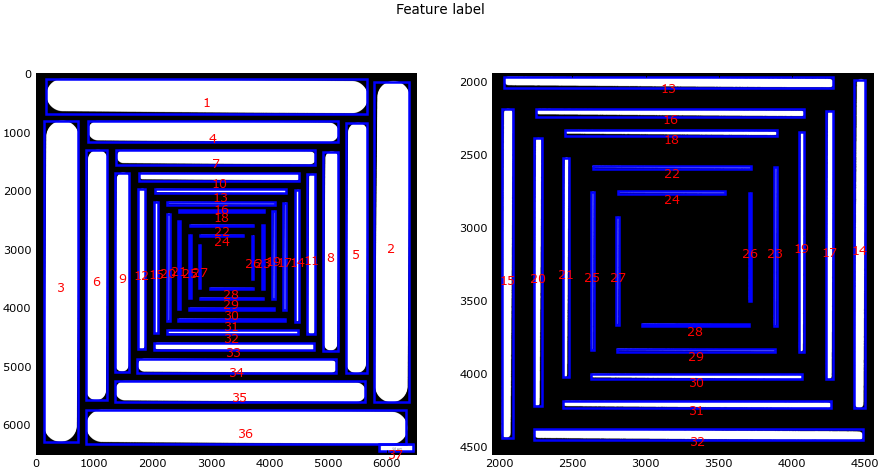

In [23]:
def plot_bboxes(ax, properties):
    for prop in properties:
        # Draw bounding box
        minr, minc, maxr, maxc = prop.bbox
        ax.add_patch(plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                   edgecolor='blue', facecolor='none', lw=2))


xlims = round(0.3 * binary.shape[1]), round(0.7 * binary.shape[1])
ylims = round(0.7 * binary.shape[0]), round(0.3 * binary.shape[0])

# Plot labels
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax0, ax1 = ax.ravel()
ax0.imshow(binary, cmap="gray")
plt.suptitle("Feature label")
plot_bboxes(ax0, properties)
for prop in properties:
    ax0.text(prop.centroid[1], prop.centroid[0], f"{prop.label}",
             color='red', fontsize=10, ha='center', va='top')

ax1.imshow(binary, cmap="gray")
plot_bboxes(ax1, properties)

for prop in properties:
    x, y = prop.centroid[1], prop.centroid[0]
    if (xlims[0] <= x <= xlims[1]) and (ylims[1] <= y <= ylims[0]):
        ax1.text(x, y, f"{prop.label}",
                 color='red', fontsize=10, ha='center', va='top')
ax1.set_xlim(*xlims)
ax1.set_ylim(*ylims)

print(f"Feature properties (lengths in units of um unless specified as number of pixels):")
display(df.head(10))

The detection has gone well. All major features have bounding boxes outlined in blue. The label assigned to each feature is given in red. This corresponds to the feature_n index in the table.

We can show the feature widths and heights using a similar method:

(4553.0, 1951.0)

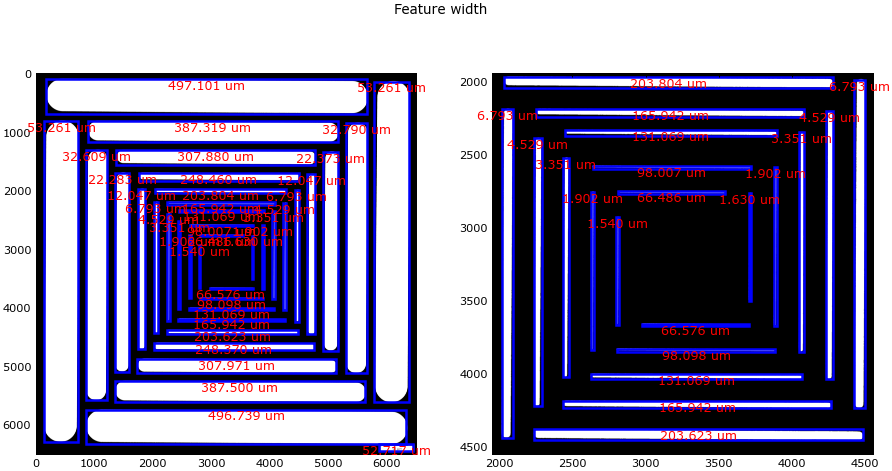

In [24]:
# Plot widths
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax0, ax1 = ax.ravel()
ax0.imshow(binary, cmap="gray")
plt.suptitle("Feature width")
plot_bboxes(ax0, properties)
for prop in properties:
    ax0.text(prop.centroid[1], prop.bbox[0],
             f"{(prop.bbox[3] - prop.bbox[1]) * pix_to_um:.3f} um",
             color='red', fontsize=10, ha='center', va='top')

ax1.imshow(binary, cmap="gray")
plot_bboxes(ax1, properties)
for prop in properties:
    x, y = prop.centroid[1], prop.centroid[0]
    if (xlims[0] <= x <= xlims[1]) and (ylims[1] <= y <= ylims[0]):
        ax1.text(prop.centroid[1], prop.bbox[0],
                 f"{(prop.bbox[3] - prop.bbox[1]) * pix_to_um:.3f} um",
                 color='red', fontsize=10, ha='center', va='top')
ax1.set_xlim(*xlims)
ax1.set_ylim(*ylims)

(4553.0, 1951.0)

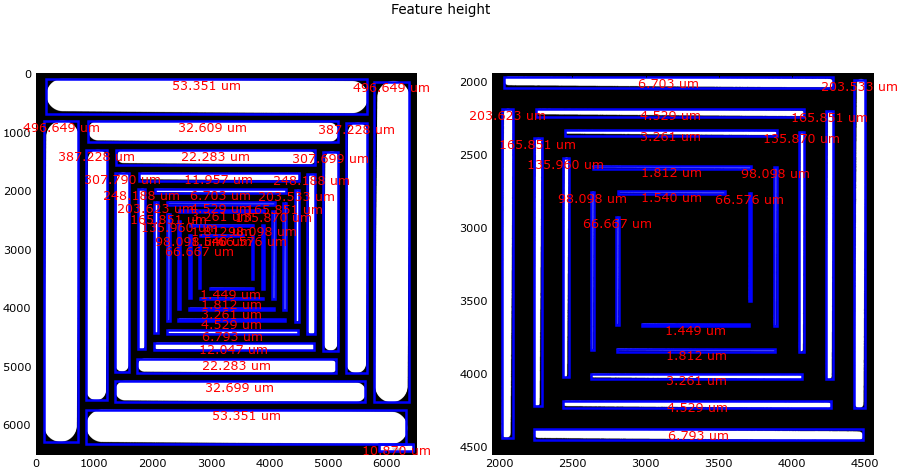

In [25]:
# Plot heights
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax0, ax1 = ax.ravel()
ax0.imshow(binary, cmap="gray")
plt.suptitle("Feature height")
plot_bboxes(ax0, properties)
for prop in properties:
    ax0.text(prop.centroid[1], prop.bbox[0],
             f"{(prop.bbox[2] - prop.bbox[0]) * pix_to_um:.3f} um",
             color='red', fontsize=10, ha='center', va='top')

ax1.imshow(binary, cmap="gray")
plot_bboxes(ax1, properties)
for prop in properties:
    x, y = prop.centroid[1], prop.centroid[0]
    if (xlims[0] <= x <= xlims[1]) and (ylims[1] <= y <= ylims[0]):
        ax1.text(prop.centroid[1], prop.bbox[0],
                 f"{(prop.bbox[2] - prop.bbox[0]) * pix_to_um:.3f} um",
                 color='red', fontsize=10, ha='center', va='top')
ax1.set_xlim(*xlims)
ax1.set_ylim(*ylims)

We can already see the narrower bars have widths significantly greater than the desired widths. For instance the narrowest bars have widths around 1.5um and a target width of 0.5um.

# Analyse lithography performance

We'd like to compare the measured bar width to the target bar width (taken from the gds file pattern). Here we're going to manually map the detected feature_n labels to the bar type and expected bar width. In practice if we were automating this process over a lot of images of a similar pattern we'd find a robust way to do this mapping automatically. Probably by ranking by particle size and position within the image.

In [13]:
# Drop feature 37 which is the scale bar
df = df.drop(37)

In [14]:
label_map = {
    'vertical_left': [3, 6, 9, 12, 15, 20, 21, 25, 27],
    'vertical_right': [2, 5, 8, 11, 14, 17, 19, 23, 26],
    'horizontal_top': [1, 4, 7, 10, 13, 16, 18, 22, 24],
    'horizontal_bottom': [36, 35, 34, 33, 32, 31, 30, 29, 28]
}

# expected width in microns
expected_width = [50, 30, 20, 10, 5, 3, 2, 1, 0.5]


for idx, row in df.iterrows():
    bar_type = [k for k, v in label_map.items() if idx in v][0]
    orientation = bar_type.split("_")[0]
    expected_bar_width = expected_width[label_map[bar_type].index(idx)]
    measured_bar_width = row["width_um"] if row["width_um"] < row["height_um"] else row["height_um"]
    df.loc[idx, "bar_type"] = bar_type
    df.loc[idx, "bar_orientation"] = orientation
    df.loc[idx, "expected_bar_width"] = expected_bar_width
    df.loc[idx, "measured_bar_width"] = measured_bar_width

dfan = df[["bar_type", "bar_orientation", "expected_bar_width", "measured_bar_width"]].sort_values(["expected_bar_width", "bar_type"])
display(dfan)

,bar_type,bar_orientation,expected_bar_width,measured_bar_width
feature_n,,,,
28,horizontal_bottom,horizontal,0.5,1.449275
24,horizontal_top,horizontal,0.5,1.539855
27,vertical_left,vertical,0.5,1.539855
26,vertical_right,vertical,0.5,1.630435
29,horizontal_bottom,horizontal,1.0,1.811594
22,horizontal_top,horizontal,1.0,1.811594
25,vertical_left,vertical,1.0,1.902174
23,vertical_right,vertical,1.0,1.902174
30,horizontal_bottom,horizontal,2.0,3.260870


Do some statics by grouping bars and taking the mean. First group by expected bar width and bar orientation. Then group even further just by expected bar width.

In [15]:
gdfan = dfan.iloc[:, 1:].groupby(["expected_bar_width", "bar_orientation"]).mean().reset_index()
gdfan["Measured - Expected (um)"] = gdfan["measured_bar_width"] - gdfan["expected_bar_width"]
gdfan["Measured / Expected (um)"] = gdfan["measured_bar_width"] / gdfan["expected_bar_width"]
display(gdfan)

,expected_bar_width,bar_orientation,measured_bar_width,Measured - Expected (um),Measured / Expected (um)
0,0.5,horizontal,1.494565,0.994565,2.989130
1,0.5,vertical,1.585145,1.085145,3.170290
2,1.0,horizontal,1.811594,0.811594,1.811594
3,1.0,vertical,1.902174,0.902174,1.902174
4,2.0,horizontal,3.260870,1.260870,1.630435
5,2.0,vertical,3.351449,1.351449,1.675725
6,3.0,horizontal,4.528986,1.528986,1.509662
7,3.0,vertical,4.528986,1.528986,1.509662
8,5.0,horizontal,6.748188,1.748188,1.349638
9,5.0,vertical,6.793478,1.793478,1.358696


In [16]:
gdfan2 = dfan.iloc[:, 2:].groupby("expected_bar_width").mean().reset_index()
gdfan2["Measured - Expected (um)"] = gdfan2["measured_bar_width"] - gdfan2["expected_bar_width"]
gdfan2["Measured / Expected (um)"] = gdfan2["measured_bar_width"] / gdfan2["expected_bar_width"]
display(gdfan2)

,expected_bar_width,measured_bar_width,Measured - Expected (um),Measured / Expected (um)
0,0.5,1.539855,1.039855,3.079710
1,1.0,1.856884,0.856884,1.856884
2,2.0,3.306159,1.306159,1.653080
3,3.0,4.528986,1.528986,1.509662
4,5.0,6.770833,1.770833,1.354167
5,10.0,12.024457,2.024457,1.202446
6,20.0,22.305254,2.305254,1.115263
7,30.0,32.676630,2.676630,1.089221
8,50.0,53.306159,3.306159,1.066123


Plot the bar width discrepencies.

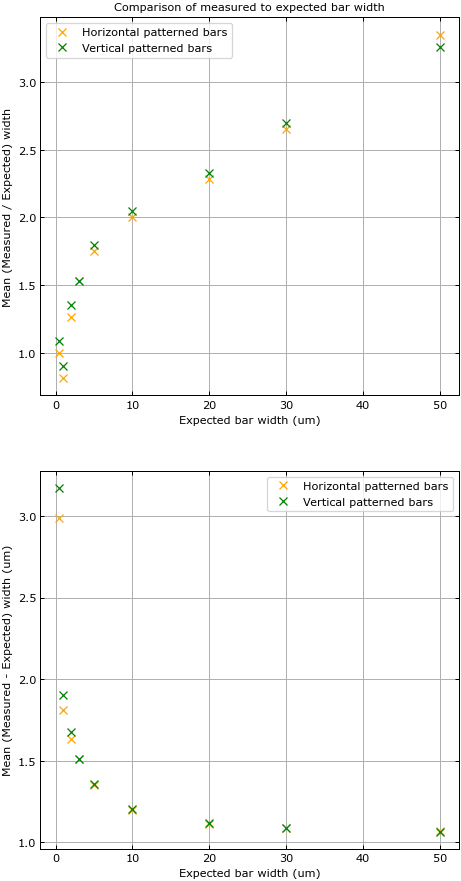

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(6, 12))
ax0, ax1 = ax.ravel()
sub1 = gdfan.loc[gdfan["bar_orientation"] == "horizontal"]
sub2 = gdfan.loc[gdfan["bar_orientation"] == "vertical"]
ax0.plot(sub1["expected_bar_width"], sub1["Measured - Expected (um)"], "x", label="Horizontal patterned bars", color="orange")
ax0.plot(sub2["expected_bar_width"], sub2["Measured - Expected (um)"], "gx", label="Vertical patterned bars")
ax0.set_xlabel("Expected bar width (um)")
ax0.set_ylabel("Mean (Measured / Expected) width")
ax0.legend()
ax0.set_title("Comparison of measured to expected bar width")
ax0.grid()

ax1.plot(sub1["expected_bar_width"], sub1["Measured / Expected (um)"], "x", label="Horizontal patterned bars", color="orange")
ax1.plot(sub2["expected_bar_width"], sub2["Measured / Expected (um)"], "gx", label="Vertical patterned bars")
ax1.set_xlabel("Expected bar width (um)")
ax1.set_ylabel("Mean (Measured - Expected) width (um)")
ax1.legend()
ax1.grid()

We see in the above plots that all bars exceed their target pattern width. Vertical patterned bars exceed their target width more than horizontal patterned bars. The mean measured bar width exceeds the reference bar width by over 3 um for the 50 um bar down to 1 um for the 0.5 um bar.

### Discussion
At a high level we can say the patterning has gone well. All calibration bars in the pattern file are present and no major defects are visible. No dirt or other impurities are detected outside of the design area.

We see from this analysis, however, that the patterned bars exceed the width of the defined lithography pattern by up to 308%. All bars are larger than the target pattern width. The mean absolute excess width is greater for the largest bar type, peaking at 3.3 um for the 50 um bars, and drops to 1.03 um for the 0.5 um bars. As a ratio though this has the greatest impact on the smallest bars which have a width 3.07x the target pattern width. The vertical bars exceed their target width more than the horizontal bars.

These results all look consistent with a basic visual inspection of the bars (see figure below). In the image we see clear smearing of the bars, particularly in the "North West" direction. This could be caused by energy leakage (maybe from in-film scattering) under the mask during the exposure process. This is consistent with the largest bars having a greater 3.3 um smearing due to the larger energy dump in these areas. The finest bars which receive fewer photons have leaked less but it has a proportionately larger impact on the desired pattern. Another possible explanation is the direction of deposition if there is overhanging resist at the edges. More information about the patterning process is needed to make a firm conclusion.

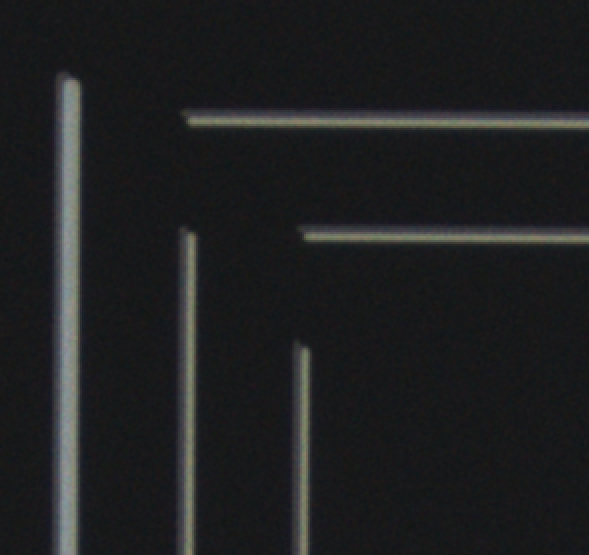

In [18]:
Image("./data/Screenshot smallest bars.png")

### Shortcomings of analysis and next steps

* The analysis above was all done on a binarized 2 colour image. When we look at the TEM image we can see the excess (smeared) portions of the bar have less intensity. This is a weakness of the above analysis and it may be interesting in future to isolate different parts of the image using more colour thresholds or other methods that don't lose the grayscale information.
* We manually related the detected features in the TEM image to their respective pattern feature in order to do the width comparison. It would be good in future to automate this process. This could be done through looking at the particle sizes and central positions and comparing them to reference values from the patterning image.
* It would be nice in future to create a difference image between the defined pattern and the imaged pattern. We could do this by exporting the GDS file in a suitable raster format then aligning the measured image with the pattern image using automated aligment tools like `skimage.registration.phase_cross_correlation`.
* We only analysed the bar widths. There are other aspects of the design we could look at, for instance shape of the bar ends or the bar spacing etc. This would be a collaboration process between the applied scientist and the fabrication experts to decide which features to attach importance to and focus on.



## Excercise questions

### Main exercise
*Considering the image below, please write code to automatically determine the features, their dimensions and analyse the data that you get from this, and include the results in the report as if you were providing feedback to the fabrication team. (High quality image of below is attached along the design file used to make this as a gds file. To read the gds file you can download and install Klayout or use any other layout editor of your choice)*

The above analysis provides a detailed analysis report to the fabrication team. By providing the report in jupyter notebook format they are able to directly see the analysis process. Adjustments can be quickly made if there is any feedback, and colleagues are able to collaborate on the work in real time. In a production fabrication process the metadata stored at the top of the file (sample number, date of measurement) should be formalised and the reports should be archived. If there is a high volume need for this particular analysis the code can be stabalised in a python package and provided as a script that anyone can run on an input image and see an automatically generated set of output report/analysis files.

### Question 1
*How would you go about writing this code if you have many repetitions of this structure on each sample, and you are trying to compare many different samples? (There is no requirement to actually write this code)*

We would first need to segment the image into sections that include just one iteration of this pattern. Then the analysis could procede as above and looped through each segment of the image separately. To automatically segment the image, one approach could be to first blur the image using a Gaussian blur. By adjusting the Gaussian sigma parameter this could have the effect of smearing the device level patterns into a single blob while leaving the devices separate. Then we can do the same binarize and `skimage.measure.label` particle detection method used above, but this time the detected particles would be the separate devices. We can then use the detected particle bounding boxes to segment the image as desired.

Ultimately though it would be better to collaborate with the fabrication/characterisation team and work to standardise the measurement process for a particular form of calibration so that less generalisation is needed for the analysis. A consistent agreed set of experiments can lead to a consistent quality and reliability of the results.

### Question 2
*Real devices often are not as clean as the image above and have many defects on or outside the designed areas, or missing pieces. How would you go about detecting those defects and tag information about their shape, size and nature? (There is no requirement to actually write this code)*

This is a difficult problem because the type and nature of the defects can be quite varied. I think a good initial approach to this task would be to follow up on the suggestion above of exporting the GDS2 file as a raster image and aligning it onto the measured pattern. By taking the difference between the two images we could highlight the areas where the deposited pattern does not match the reference pattern. We can then do particle analysis on these areas of difference to measure their shape and size.

Additionally following the standard detection process above we can reject smaller particles that may be detected if there is visble contamination material outside of the designed areas.

These are reasonable general approaches to start and they could be an initial warning flag for a measured image. To really look at a general defect in detail though is difficult to automate. If there was a specific type of defect that was of concern which had some specific characteristics it would be good to work with the fabrication team to find a way to detect and quantify them.

### Question 3
*How would you deal with images with different brightness/contrast (example above. There is no requirement to actually write this code)*

The method given above should cope reasonably well if the imager brightness/contrast changes. The Otsu thresholding method is designed to find a threshold in the colour histogram that gives the best contrast between two peaked distributions of colour. If the contrast is very bad it might fail and more work would need to be done. But at that point for a basic pattern like this it's more likely to be an issue with the TEM measurement and the measurement process would need more thought. Perhaps contrast could be improved by changing the deposition material for instance.

